In [1]:
# installing keras tuner
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


In [2]:
# imports
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)
import keras_tuner as kt
import matplotlib.pyplot as plt

In [3]:
# loading the mnist dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# checking the shapes
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [5]:
# normalizing the pixel values in range of 0 to 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
# checking the changes
X_train.min(), X_train.max()

(0.0, 1.0)

In [7]:
# defining the search space

def model_builder(hp):

  model = tf.keras.Sequential()

  # flatten layer
  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  
  # hidden layers
  for i in range(hp.Int('hidden_layers', min_value=2, max_value=4)):
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units' + str(i), min_value=40, max_value=80, step=10),
        activation=hp.Choice('activation' + str(i), values=['relu', 'tanh', 'sigmoid'])
    ))
  
  # output layer
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

  # compilation
  model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  # get the model
  return model

In [8]:
# creating a tuner object
tuner = kt.RandomSearch(hypermodel=model_builder, objective='val_accuracy', 
                        max_trials=4, directory='mydir', project_name='diabetes', seed=18)

In [9]:
# getting the hps summary
tuner.search_space_summary()

Search space summary
Default search space size: 6
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 80, 'step': 10, 'sampling': 'linear'}
activation0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 80, 'step': 10, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [10]:
# searching for the best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=0)

In [11]:
# checking the results 
tuner.results_summary(num_trials=1)

Results summary
Results in mydir/diabetes
Showing 1 best trials
Trial summary
Hyperparameters:
hidden_layers: 3
units0: 50
activation0: tanh
units1: 40
activation1: tanh
optimizer: adam
units2: 80
activation2: tanh
units3: 60
activation3: relu
Score: 0.9670000076293945


In [12]:
# fetching the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [13]:
# getting the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                39250     
                                                                 
 dense_5 (Dense)             (None, 40)                2040      
                                                                 
 dense_6 (Dense)             (None, 80)                3280      
                                                                 
 dense_7 (Dense)             (None, 10)                810       
                                                                 
Total params: 45,380
Trainable params: 45,380
Non-trainable params: 0
_________________________________________________________________


In [14]:
# model training with the best hyperparameters
history = model.fit(X_train, y_train, epochs=40, initial_epoch=6, validation_data=(X_test, y_test), verbose=0)

In [15]:
# checking the model performance
_, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Training: {}, Testing: {}'.format(round(train_accuracy * 100, 2), round(test_accuracy * 100, 2)))

Training: 99.79, Testing: 97.06


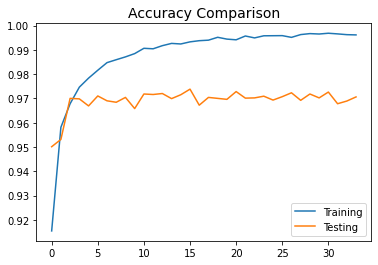

In [16]:
# plotting the accuracy
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Accuracy Comparison', size=14)
plt.legend();

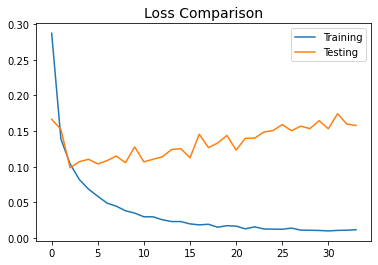

In [17]:
# plotting the loss
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.title('Loss Comparison', size=14)
plt.legend();